# Single Cell Sequencing
## Gene discovery exploration

Here we explore the traspose matrix, meaning how genes are close to each other. 

The idea is to explore genes that have similar expression, ergo could have similar funcionality (gene discovery procesure).

For that aim, we normalize each gene counting among cells between 0 and 1, and we reduce the dimensinality using umap transformation. Later we measure distance in the umap space (also could be done in the original space).

For measuring distance at first instance we are using euclidean distance. We have to explore different measures for similarity to check results and expand to other possibles genes. 

We use as an input adata file after quality control : campari_scs.h5ad

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import anndata as ad
import hdf5plugin
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os 
#external modules
#pretty plotting
import seaborn as sb
import sys 
import config as general_paths
import warnings
warnings.filterwarnings("ignore")
sb.set_context(context='poster')

import copy

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

scanpy==1.9.8 anndata==0.9.2 umap==0.5.5 numpy==1.24.4 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11


In [2]:
figure_path = general_paths.figures_path
data_path = general_paths.data_path
output_path = general_paths.output_path
local_path = general_paths.local_path
input_path = output_path

## SECTION I: Data loading

Loading adata information that has been agregated and quality controled

In [3]:
# figure_path = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\figuresR'
# input_path = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\out'


adata_umap_path = os.path.join(input_path,'control_scs_umap_from_R.h5ad')
matlab_file_umap_export = "plate1_till_7_ilonas_genes_umap_"

NO_PCA = 20

In [4]:
adata = ad.read_h5ad(adata_umap_path)
adata

AnnData object with n_obs × n_vars = 2422 × 16000
    obs: 'barcode', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'louvain_r0.5', 'louvain_r1', 'louvain_r1.5', 'louvain_r2', 'louvain_r2.5'
    var: 'gene_id', 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'louvain', 'louvain_r0.5_colors', 'louvain_r1.5_colors', 'louvain_r1_colors', 'louvain_r2.5_colors', 'louvain_r2_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## SECTION II: Analysis for gene discovery


In [5]:
x = adata.X

Text(0.5, 1.0, 'Genes Normalized')

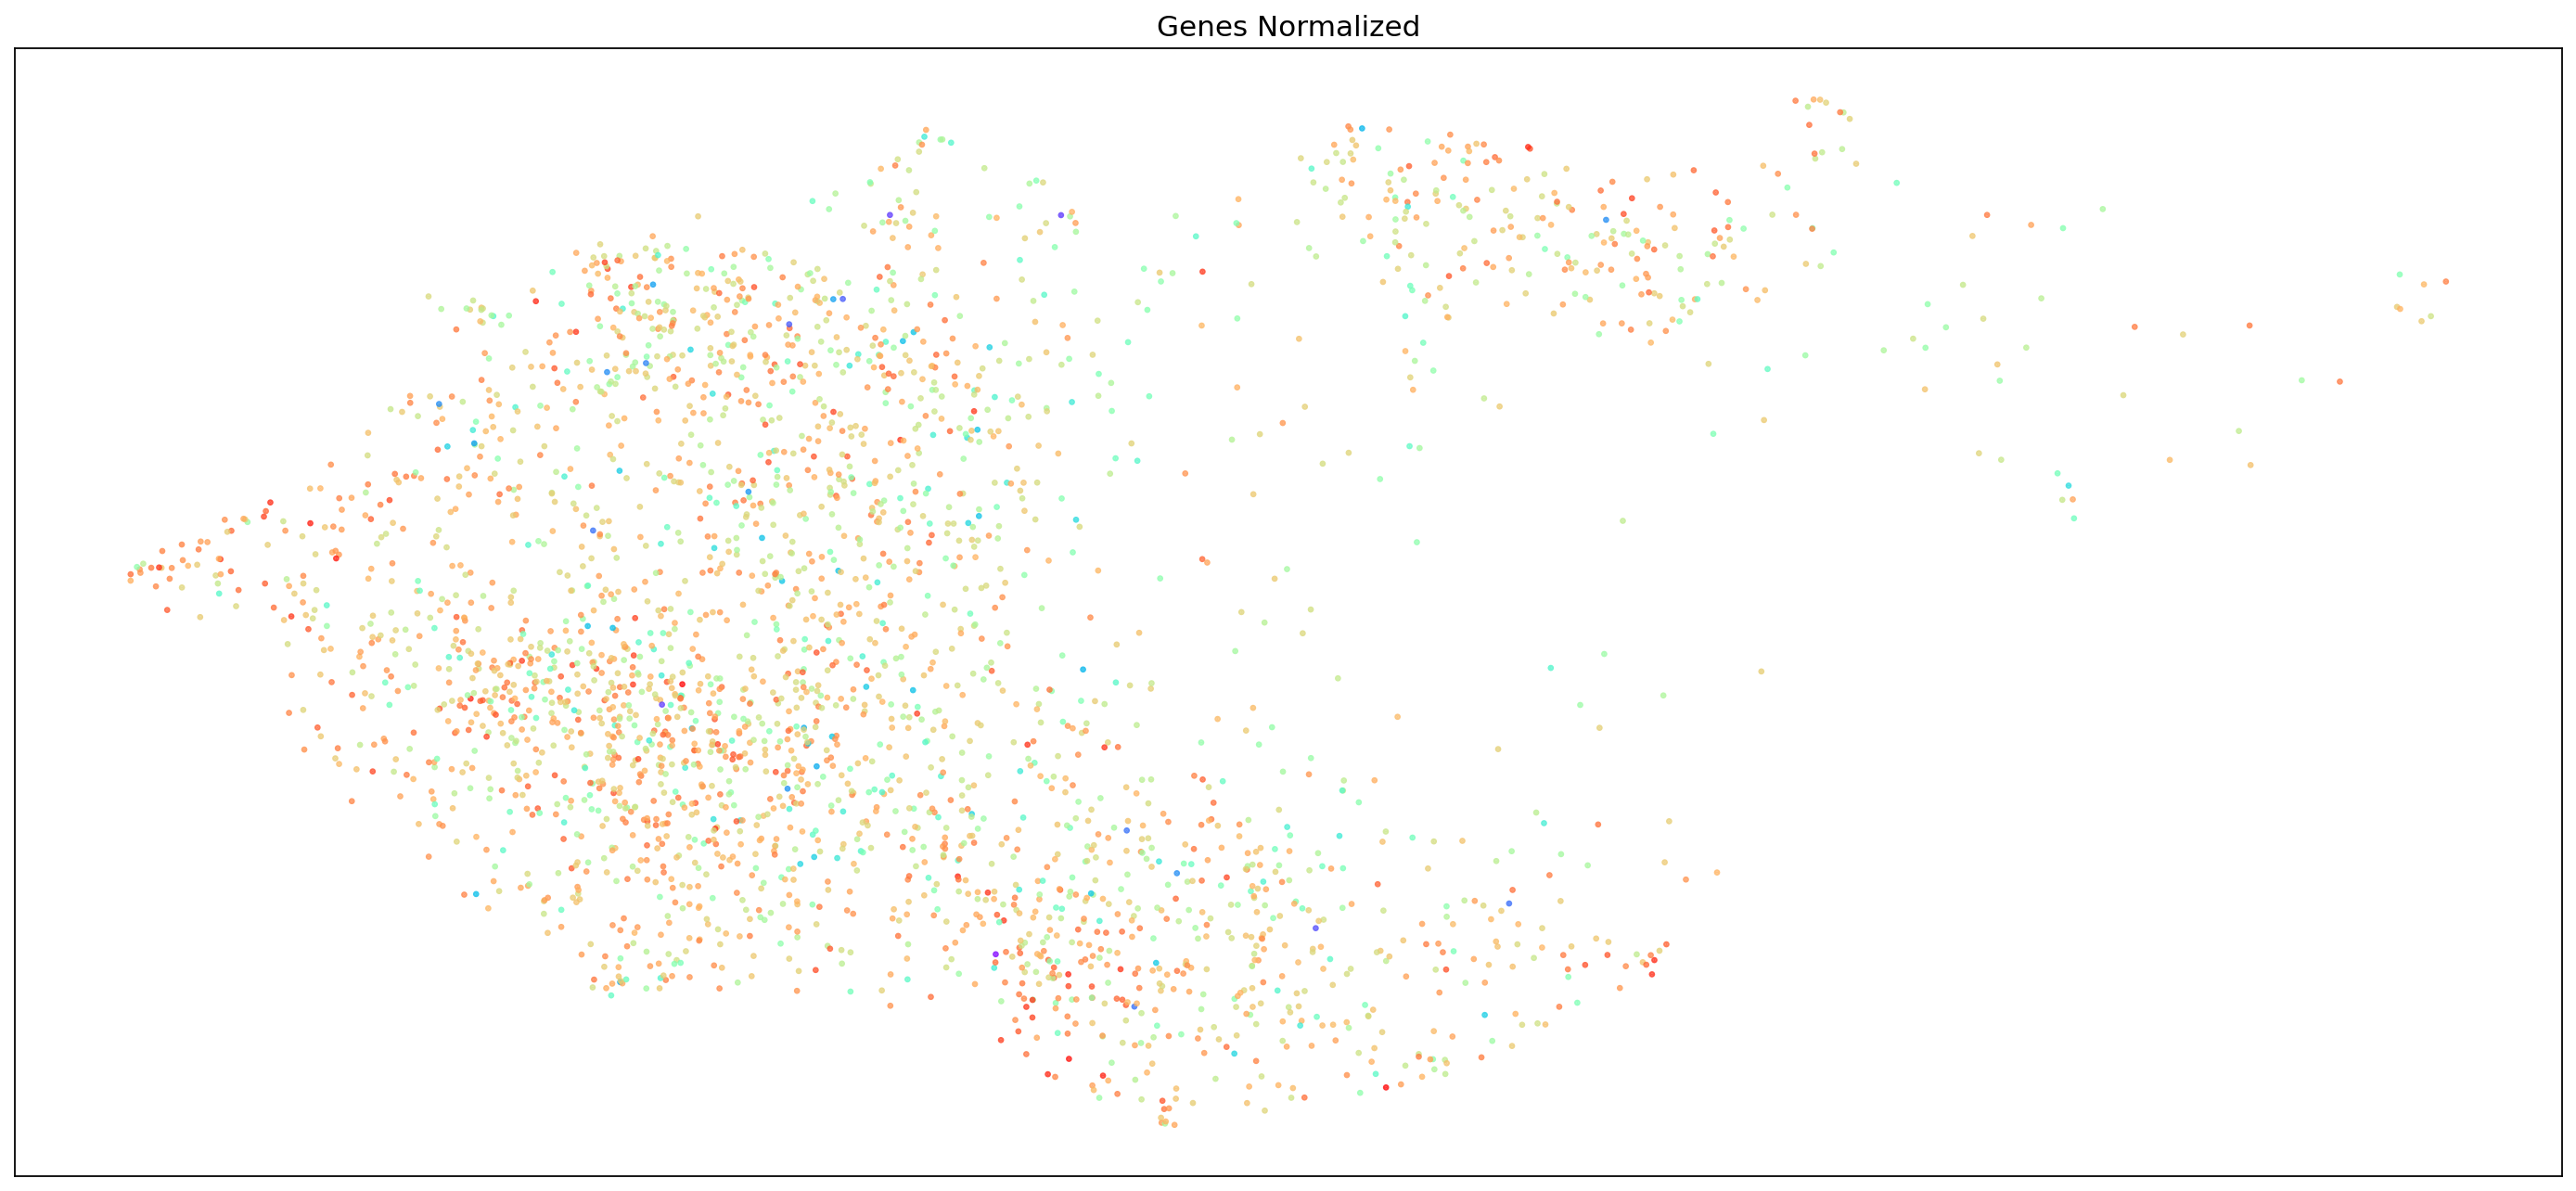

In [6]:
### create a umap embedding in the genes x genes space
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
from scanpy._utils import NeighborsView


neighbors_key = 'neighbors'
neighbors = NeighborsView(adata, neighbors_key)
if 'params' not in neighbors or neighbors['params']['method'] != 'umap':
        logg.warning(
            f'.obsp["{neighbors["connectivities_key"]}"] have not been computed using umap'
        )
n_neighbors = neighbors['params']['n_neighbors']

scaled_data = StandardScaler().fit_transform(x)
scaled_data = (scaled_data.T - np.min(scaled_data, axis = 1))/ (np.max(scaled_data, axis = 1).reshape(-1) - np.min(scaled_data, axis = 1).reshape(-1))

pca1 = PCA(NO_PCA)
pca1.fit(scaled_data)
pca_embedding = pca1.transform(scaled_data)
reducer = umap.UMAP(n_components= 2,n_neighbors=n_neighbors,min_dist = 0.5,spread= 1.0, init= 'spectral', negative_sample_rate=5,
                    random_state= 0,verbose=sc.settings.verbosity > 3)
umap_embedding = reducer.fit_transform(pca_embedding)
expression_count = np.sum(x.T,axis = 1)
rcParams['figure.figsize']=(22,10)
figure, axes = plt.subplots(1,1)
axes.scatter(umap_embedding[:,0],umap_embedding[:,1], s= 1,alpha = 0.8, c = np.log(expression_count), cmap = 'rainbow')
# axes.scatter(umap_embedding[:,0],umap_embedding[:,1], s= 1,alpha = 0.3, c = np.log(expression_count), cmap = 'rainbow')
axes.set_xticks([])
axes.set_yticks([])
axes.set_title('Genes Normalized')


In [7]:
###########################################################
# NEW MELISAS
# gets distances in umap space and normalized space
#########################################################

gene_name = []
for i in range(len(adata.var['gene_name'])):
    gene_name.append(adata.var['gene_name'].iloc[i])

    
marker_genes = ['Ntrk2','Cd34','Nppb','Mrgprb4','Mrgpra3','Mrgprd','Sstr2','Adra2a','Smr2',
                'Bmpr1b','Nefh','Pvalb','Adm',
                'Trpm3','Piezo2','Piezo1','Trpm2','Smr2','Sstr2','Bmpr1b','Trpm8','Trpv1','Nppb',
                'Sst','Pvalb','Prokr2','Mrgprd','Mrgpra3','Cd34',
                'Th','Trpa1','Ntrk3','Ntrk2','Ntrk1','Ret','Tac1','Calca','Calcb','Nefh',
                'S100b','Scn10a','Slc17a8','Atf3','Pou4f3','Calb1','Avil','Asic3',
                'Asic2','Asic1','Pou6f2','Avpr1a','Pou4f2','Sox10','Chrna7','Chrna3',
                'P2rx3','Gfra2','Ldhb','Necab2','Spp1','Adra2a','Chrna7','Tafa4']

marker_position = np.zeros((len(marker_genes),))
count = 0
for marker in  marker_genes:
    index = gene_name.index(marker)
    marker_position[count] = index
    count = count+1

n = 20 # how many closest genes we want


nearest_neighbors = np.zeros((n, len(marker_genes)))            # umap distance
nearest_neighbors_distance = np.zeros((n, len(marker_genes)))   # umap distance
auxiliar_distance = np.zeros((umap_embedding.shape[0]))         # umap distance

nearest_neighbors_ = np.zeros((n, len(marker_genes)))           # normalized distance
nearest_neighbors_distance_ = np.zeros((n, len(marker_genes)))  # normalized distance
auxiliar_distance_ = np.zeros((umap_embedding.shape[0]))        # normalized distance

for i in range(len(marker_genes)):
    a = umap_embedding[int(marker_position[i]),:] # one gene (distnace in umap space)
    a_ = x.T[int(marker_position[i]),:] # (distnace in normalized projection)
    for j in range(umap_embedding.shape[0]):
        b = umap_embedding[j,:] # the other gene
        b_ = x.T[j,:]
        dist = np.linalg.norm(a-b)
        auxiliar_distance[j] = dist
        dist_ = np.linalg.norm(a_-b_)
        auxiliar_distance_[j] = dist_
    sorted_arguments = np.argsort(auxiliar_distance)
    nearest_neighbors_distance[:,i] = auxiliar_distance[sorted_arguments[0:n]]
    nearest_neighbors[:,i] = sorted_arguments[0:n].astype(int)
    
    sorted_arguments_ = np.argsort(auxiliar_distance_)
    nearest_neighbors_distance_[:,i] = auxiliar_distance_[sorted_arguments_[0:n]]
    nearest_neighbors_[:,i] = sorted_arguments_[0:n].astype(int)

    


In [8]:
# get closest genes in umap space
closest_genes = []
dfs = []
for i in range(len(marker_genes)):
    closest_genes_ = []
    for j in range(n):
        closest_genes_.append(gene_name[int(nearest_neighbors[j,i])])
    closest_genes.append(closest_genes_)
    df = pd.DataFrame({marker_genes[i]:closest_genes_})
    dfs.append(df)
    

In [9]:
# get closest genes in normalized space
closest_genes_norm = []
dfs_norm = []
for i in range(len(marker_genes)):
    closest_genes_ = []
    for j in range(n):
        closest_genes_.append(gene_name[int(nearest_neighbors_[j,i])])
    closest_genes_norm.append(closest_genes_)
    df = pd.DataFrame({marker_genes[i]:closest_genes_})
    dfs_norm.append(df)

In [10]:
# create 2 dataframes with genes as columns and their nearby genes as rows (for Melisa to compare)
closest_from_umap_df = pd.concat(dfs,axis=1)
closest_from_normalized_df = pd.concat(dfs_norm,axis=1)
closest_from_umap_df.to_csv(os.path.join(input_path,'closest_from_umap.csv'),header=False,index=False)
closest_from_normalized_df.to_csv(os.path.join(input_path,'closest_from_normalized.csv'),header=False,index=False)


In [11]:
#####################################################################
# Check and compare closest genes in umap space and normalized space
interesting_gene = 'Piezo2'

def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

def complement_intersection(list1,list2):
    non_intersection = list(set(list1) ^ set(list2))
    return non_intersection

index = marker_genes.index(interesting_gene)
closest_genes_for_this = closest_genes[index]
closest_genes_for_this_ = closest_genes_norm[index]

print('Umap:', closest_genes_for_this)
#print('Distance Normalization:', nearest_neighbors_distance[:,index])
print('Normalized Space:' , closest_genes_for_this_)
#print('Distance Normalization + cut:', nearest_neighbors_distance_cut[:,index])
intersection_genes = intersection(closest_genes_for_this,closest_genes_for_this_)
complement_genes = complement_intersection(closest_genes_for_this,closest_genes_for_this_)
print('Intersection:' , intersection_genes)
print('Complement:' , complement_genes)

Umap: ['Piezo2', 'Epb41l4a', 'Fkbp7', 'Gm13373', 'Plppr1', '9530026P05Rik', 'Cmbl', 'Id4', 'Maz', 'A130051J06Rik', 'Il17rd', 'Ifngr2', 'Ppp1r3b', 'Efr3b', 'Nell2', 'Tnfrsf11a', 'Fxyd6', 'Asph', 'Fars2', 'Myo10']
Normalized Space: ['Piezo2', 'P2ry1', 'Prune2', 'Kcnd3', 'Slit1', 'Tmem132e', 'Casz1', 'Fat3', 'Tmem72', 'Lrrn1', 'Kcnd1', 'Stac2', 'Abtb2', 'Asap1', 'Sv2c', 'Osbpl6', 'Myo1a', 'Rtn4rl1', 'Scn7a', 'Brap']
Intersection: ['Piezo2']
Complement: ['Gm13373', 'Maz', 'Il17rd', 'Nell2', 'Asap1', 'Slit1', 'Brap', 'Abtb2', 'Fars2', '9530026P05Rik', 'Kcnd3', 'Osbpl6', 'Fxyd6', 'Epb41l4a', 'Sv2c', 'Stac2', 'Tnfrsf11a', 'Efr3b', 'P2ry1', 'Plppr1', 'Cmbl', 'Ifngr2', 'Scn7a', 'Kcnd1', 'Prune2', 'Tmem72', 'Fkbp7', 'Ppp1r3b', 'Fat3', 'Id4', 'Lrrn1', 'A130051J06Rik', 'Asph', 'Rtn4rl1', 'Myo1a', 'Casz1', 'Myo10', 'Tmem132e']


In [12]:
# # Test closest genes
# gene = 'Th'
# index= marker_genes.index(gene)
# closest_genes[index]

In [16]:
##############################################################
## Show our in umap space
# show plot as pop-up
%matplotlib tk 
rcParams['figure.figsize']=(15,10)
figure, axes = plt.subplots()

axes.scatter(umap_embedding[:,0],umap_embedding[:,1], s= 1, c = 'gray', alpha = 0.2)

marker_genes_plotting = marker_genes

for interesting_gene in marker_genes_plotting:
    index = marker_genes.index(interesting_gene)
    # closest_genes_for_this = closest_genes[index]
    #axes.scatter(umap_embedding[nearest_neighbors[1:,index].astype(int),0],umap_embedding[nearest_neighbors[1:,index].astype(int),1], s= 1, c = 'k')
    # in umap space
    axes.scatter(umap_embedding[nearest_neighbors[0,index].astype(int),0],umap_embedding[nearest_neighbors[0,index].astype(int),1], s= 15)
    axes.annotate(interesting_gene, (umap_embedding[nearest_neighbors[0,index].astype(int),0], umap_embedding[nearest_neighbors[0,index].astype(int),1]),fontsize = 8, color= 'k')

axes.grid(False)
axes.set_axis_off()
axes.set_xticks([])
axes.set_yticks([])
axes.set_title('Genes distances Umap space')
figure.tight_layout()

figure.savefig(os.path.join(figure_path , 'genes_in_umap_space.png'))

In [14]:
# ##############################################################
# ## Show our genes in normalized space
# rcParams['figure.figsize']=(15,10)
# figure, axes = plt.subplots()

# axes.scatter(umap_embedding[:,0],umap_embedding[:,1], s= 1, c = 'gray', alpha = 0.2)

# for interesting_gene in marker_genes_plotting:
#     index = marker_genes.index(interesting_gene)
#     closest_genes_for_this_ = closest_genes_norm[index]
#     # in normalized space
#     axes.scatter(umap_embedding[nearest_neighbors_[0,index].astype(int),0],umap_embedding[nearest_neighbors_[0,index].astype(int),1], s= 15)
#     axes.annotate(interesting_gene, (umap_embedding[nearest_neighbors_[0,index].astype(int),0], umap_embedding[nearest_neighbors_[0,index].astype(int),1]),fontsize = 8, color= 'k')

# axes.grid(False)
# axes.set_axis_off()
# axes.set_xticks([])
# axes.set_yticks([])
# axes.set_title('Genes distances Normalized space')
# figure.tight_layout()

# figure.savefig(os.path.join(figure_path , 'genes_in_normalized_space.png'))

In [15]:
#############################################################################################################
#############################################################################################################
#############################################################################################################
#################### HERE WE EXPORT ALL THE INFORMATION FOR GENES AS .MAT ################
from time import strftime
from datetime import datetime
today = datetime.now().strftime("%Y_%m_%d")

data = {'umap_embedding_norm': umap_embedding,'genes': gene_name}
scipy.io.savemat(os.path.join(input_path , matlab_file_umap_export+today+'.mat'), data)        

#############################################################################################################
#############################################################################################################
#############################################################################################################